In [1]:
import warnings, sys, os, glob, joblib, ast
from functools import reduce
from brainiak.eventseg.event import EventSegment
import nibabel as nib
from scipy.stats import zscore, norm

from matplotlib import pyplot as plt
import seaborn as sns, pandas as pd, numpy as np
import matplotlib.patches as patches

from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy.stats import pearsonr, spearmanr



## confirm number of subjects, neurons, trials

In [2]:
# norm_choice = 'shortest_baseline'
# norm_choice = 'session_baseline'
norm_choice = 'self'
# norm_choice = 'nothing'
print(f'df normalized by {norm_choice}\n')

df = pd.read_pickle(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.pkl')
# df = pd.read_csv(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.csv')
print(f'{df["neuron"].nunique()} total neurons\n')

# identify neurons with zero firing rate in encoding or baseline
zero_FR_neurons = df[(df['FR'] == 0) & (df['stim_phase'].isin(['encoding', 'baseline']))]['neuron'].unique()
print(f'{len(zero_FR_neurons)} neurons dropped because FR = 0 in encoding or baseline: {zero_FR_neurons}\n')

# drop these neurons
df_filtered = df[~df['neuron'].isin(zero_FR_neurons)]
df_encoding = df_filtered[df_filtered['stim_phase'] == 'encoding']
num_subjs, num_sess, num_neurons = len(np.unique(df_encoding['subj'])), len(np.unique(df_encoding['sess'])), len(np.unique(df_encoding['neuron']))

print(f'{num_neurons} neurons, {num_sess} sessions, {num_subjs} subjects')
print(f'{len(df_encoding)} rows in df\n')

no_fMRI_subjs = ['P49', 'P55', 'P56', 'P57', 'P58']
print(f'subjs who didnt undergo fMRI: {no_fMRI_subjs}\n')

scene_cells = ['P42CS_R1_47_2_1347_7', 'P42CS_R2_42_3_1096_7', 'P43CS_R1_59_3_1929_1', 'P43CS_R1_76_4_1276_10', 'P43CS_R2_29_1_2303_2',
               'P44CS_R1_15_2_835_8', 'P47CS_R1_10_2_900_8', 'P47CS_R1_18_1_1631_4', 'P47CS_R1_22_4_1379_4', 'P47CS_R1_68_1_964_9',
               'P47CS_R1_74_2_1575_10', 'P47CS_R1_78_1_2233_10', 'P47CS_R2_19_2_3139_4', 'P47CS_R2_20_4_2437_4', 'P47CS_R2_47_1_1478_7',
               'P48CS_R1_9_1_678_8', 'P48CS_R1_21_2_873_4', 'P48CS_R1_30_1_1720_2', 'P48CS_R1_43_2_3181_7', 'P48CS_R2_48_2_936_7',
               'P48CS_R2_58_8_6571_1', 'P49CS_R1_7_1_2581_6', 'P49CS_R2_67_1_1165_10', 'P51CS_R1_48_1_2072_8', 'P51CS_R2_40_3_2542_5',
               'P51CS_R2_80_1_794_9', 'P53CS_R1_10_1_2456_8', 'P53CS_R2_6_4_5480_6', 'P53CS_R2_16_2_6444_8', 'P54CS_R1_17_2_3943_4',
               'P54CS_R1_45_1_2172_7', 'P54CS_R1_54_3_4177_3', 'P54CS_R1_55_2_6861_3', 'P54CS_R1_56_1_1540_3', 'P54CS_R1_70_3_5181_10',
               'P54CS_R2_13_4_7736_8', 'P54CS_R2_67_1_4703_10', 'P55CS_R2_18_2_1050_4', 'P55CS_R2_45_1_1206_7', 'P55CS_R2_48_1_36_7',
               'P56CS_R1_9_1_3423_8', 'P56CS_R1_13_1_999_8', 'P56CS_R1_19_1_1458_4', 'P57CS_R1_66_1_2442_10', 'P57CS_R2_9_1_740_8',
               'P57CS_R2_15_2_1738_8', 'P57CS_R2_70_2_1978_10', 'P58CS_R1_34_3_3299_5', 'P58CS_R1_34_4_3301_5', 'P58CS_R1_35_4_2476_5',
               'P58CS_R1_56_1_3134_3', 'P58CS_R1_57_3_2783_1', 'P58CS_R1_60_1_1424_1', 'P58CS_R1_62_2_3305_1', 'P58CS_R1_63_2_3170_1',
               'P60CS_R1_39_1_1408_5', 'P60CS_R1_54_1_571_3', 'P60CS_R1_56_1_1106_3', 'P62CS_R1_30_3_6240_3', 'P62CS_R2_22_2_2532_7']

sessions_with_scene_cells = np.unique([cell[:8] for cell in scene_cells])
print(f'{len(sessions_with_scene_cells)} sessions with scene cells: {sessions_with_scene_cells}\n')

print(f'{len(scene_cells)} scene selective cells')

df_encoding.head()


df normalized by self

1457 total neurons

19 neurons dropped because FR = 0 in encoding or baseline: ['P43CS_R2_76_1_990_10' 'P47CS_R1_19_4_1280_4' 'P47CS_R1_52_1_298_3'
 'P47CS_R2_22_1_8375_4' 'P48CS_R1_24_1_2297_4' 'P48CS_R1_57_1_753_1'
 'P48CS_R2_58_3_6420_1' 'P48CS_R2_62_2_2097_1' 'P49CS_R2_64_1_4257_1'
 'P51CS_R2_48_4_5337_7' 'P53CS_R1_37_1_3731_5' 'P54CS_R1_70_2_5145_10'
 'P54CS_R2_31_1_2534_2' 'P55CS_R1_49_2_5469_3' 'P55CS_R1_54_1_3978_3'
 'P57CS_R2_51_1_624_3' 'P62CS_R1_27_3_8498_3' 'P62CS_R1_29_3_8468_3'
 'P62CS_R1_32_6_6115_3']

1438 neurons, 29 sessions, 16 subjects
1438 rows in df

subjs who didnt undergo fMRI: ['P49', 'P55', 'P56', 'P57', 'P58']

25 sessions with scene cells: ['P42CS_R1' 'P42CS_R2' 'P43CS_R1' 'P43CS_R2' 'P44CS_R1' 'P47CS_R1'
 'P47CS_R2' 'P48CS_R1' 'P48CS_R2' 'P49CS_R1' 'P49CS_R2' 'P51CS_R1'
 'P51CS_R2' 'P53CS_R1' 'P53CS_R2' 'P54CS_R1' 'P54CS_R2' 'P55CS_R2'
 'P56CS_R1' 'P57CS_R1' 'P57CS_R2' 'P58CS_R1' 'P60CS_R1' 'P62CS_R1'
 'P62CS_R2']

60 scene selective 

subj      sess                neuron    region  start_time  stop_time  \
0    P41  P41CS_R1   P41CS_R1_21_1_679_4  amygdala         0.0  478.85512   
42   P41  P41CS_R1   P41CS_R1_38_1_613_5       ACC         0.0  478.85512   
84   P41  P41CS_R1  P41CS_R1_39_1_1359_5       ACC         0.0  478.85512   
126  P41  P41CS_R1  P41CS_R1_40_1_2816_5       ACC         0.0  478.85512   
168  P41  P41CS_R1  P41CS_R1_40_2_2821_5       ACC         0.0  478.85512   

            RT                                       trial_spikes  \
0    478.85512  [3.43207675, 4.39507675, 5.16801325, 5.2624507...   
42   478.85512  [0.2510465, 2.07970175, 4.70126325, 5.09220075...   
84   478.85512  [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...   
126  478.85512  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...   
168  478.85512  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...   

                                  trial_aligned_spikes  num_spikes        FR  \
0    [3.43207675, 4.39507675, 5.16801325, 5.2624507...         360  0.751793   
42   [0.2510465, 2.07970175, 4.70126325, 5.09220075...         278  0.580551   
84   [0.3880465, 1.5347965, 1.61257775, 2.0414215, ...         949  1.981810   
126  [0.0642965, 0.80051525, 0.813359, 0.89145275, ...        1820  3.800732   
168  [0.4351715, 0.88882775, 1.79107775, 3.7156705,...         379  0.791471   

                                   trial_smooth_spikes  trial_smooth_FR  \
0    [-1.2730946020175409, -0.710811152793127, -0.1...     4.841224e-17   
42   [0.1727115902171085, -0.4970723816004588, 0.17...    -5.958430e-17   
84   [-0.4841462836799911, -0.7340789431121942, -0....     9.682448e-17   
126  [-1.277785091028816, -1.9862354843888455, -0.8...     9.682448e-17   
168  [0.3583427024917564, -0.2133277626874002, -0.7...    -4.841224e-17   

    stim_phase stimulus_file response_correct response_confidence  \
0     encoding      bd_movie              NaN                 NaN   
42    encoding      bd_movie              NaN                 NaN   
84    encoding      bd_movie              NaN                 NaN   
126   encoding      bd_movie              NaN                 NaN   
168   encoding      bd_movie              NaN                 NaN   

    actual_response  
0               NaN  
42              NaN  
84              NaN  
126             NaN  
168             NaN

## dropping neurons with >16s blocks of no spikes

In [3]:
neurs_to_drop = []
recording_block_sz = 16 # time chunks of recording neurons

# loop through each neuron row in df_encoding
for neur_idx, neur_row in df_encoding.iterrows():

    # get recording duration and spikes for the current neuron
    RT = int(neur_row['RT'])
    spike_train = np.array(neur_row['trial_aligned_spikes'])

    t1, toDrop = 0, False
    
    # go through trial to find empty blocks
    while t1 < RT - recording_block_sz:

        block_spikes = spike_train[(t1 <= spike_train) & (spike_train < t1 + recording_block_sz)]
        t2 = t1

        if not np.any(block_spikes):
            
            toDrop = True

            # find next t where spikes occurs, as this will mark the end of the empty block
            for t2 in range(t1 + recording_block_sz, RT):
                
                bigger_block_spikes = spike_train[(t1 <= spike_train) & (spike_train < t2)]
                if np.any(bigger_block_spikes):
                    break
                    
        if toDrop:
            neurs_to_drop.append(neur_idx)
            break

        t1 = t2+1

print(f'total neurons {len(df_encoding)}')
df_encoding = df_encoding.drop(neurs_to_drop).reset_index(drop=True)
print(f'retained neurons {len(df_encoding)}')
print(df_encoding.groupby('region').size())

total neurons 1438
retained neurons 1046
region
ACC            171
amygdala       329
hippocampus    193
preSMA         237
vmPFC          116
dtype: int64


## get scene cut info

In [4]:
# 1. all cuts
cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
cuts = cuts_df['shot_start_t'].tolist()
print(f'{len(cuts)} total cuts, at indices {cuts}')

# 2. scene cuts
scene_cut_inds = [0] # 1st frame is always a scene cut
scene_cut_inds.extend(np.where(np.diff(cuts_df['scene_id']) != 0)[0] + 1)
scene_cuts = [cuts[i] for i in scene_cut_inds]
print(f'{len(scene_cuts)} scene cuts at t: {scene_cuts}')

# 3. color code all & scene cuts
cuts_df['cut_colors'] = 'grey'
cuts_df.loc[scene_cut_inds, 'cut_colors'] = 'red'
cuts_df.head(15)

93 total cuts, at indices [0.0, 4.72, 15.0, 16.72, 19.08, 21.72, 25.08, 27.08, 37.64, 46.16, 66.28, 66.8, 90.16, 92.72, 94.88, 99.32, 103.64, 108.28, 113.44, 115.0, 117.96, 120.0, 121.88, 126.52, 129.2, 137.56, 140.36, 143.36, 145.24, 147.88, 149.4, 150.76, 153.4, 153.92, 159.08, 161.16, 163.08, 167.28, 169.04, 170.68, 171.84, 173.48, 184.92, 211.6, 217.48, 254.24, 256.12, 261.6, 264.84, 266.68, 269.24, 273.04, 277.28, 281.28, 284.56, 288.76, 291.44, 307.88, 314.48, 328.52, 340.76, 346.2, 350.0, 357.84, 360.0, 362.56, 364.92, 367.76, 369.44, 371.64, 389.64, 407.88, 409.72, 419.04, 420.24, 424.36, 427.64, 428.72, 431.52, 433.48, 435.0, 437.52, 439.6, 442.28, 445.24, 450.04, 451.4, 453.04, 453.88, 456.44, 456.96, 459.32, 475.44]
13 scene cuts at t: [0.0, 27.08, 37.64, 46.16, 66.8, 184.92, 254.24, 314.48, 328.52, 340.76, 433.48, 435.0, 437.52]


scene_id  shot_start_fr  shot_start_t  shot_dur_t    location  \
0        1.0            1.0          0.00        4.72    backyard   
1        1.0          119.0          4.72       10.28    backyard   
2        1.0          376.0         15.00        1.72    backyard   
3        1.0          419.0         16.72        2.36    backyard   
4        1.0          478.0         19.08        2.64    backyard   
5        1.0          544.0         21.72        3.36    backyard   
6        1.0          628.0         25.08        2.00    backyard   
7        2.0          678.0         27.08       10.56  livingroom   
8        3.0          942.0         37.64        8.52     bedroom   
9        4.0         1155.0         46.16       20.12     bedroom   
10       4.0         1658.0         66.28        0.52     bedroom   
11       5.0         1671.0         66.80       23.36     bedroom   
12       5.0         2255.0         90.16        2.56     bedroom   
13       5.0         2319.0         92.72        2.16     bedroom   
14       5.0         2373.0         94.88        4.44     bedroom   

          cut_type  cut_dur_t  cut_dur_fr cut_colors  
0              cut       0.00           0        red  
1              cut       0.00           0       grey  
2              cut       0.00           0       grey  
3              cut       0.00           0       grey  
4              cut       0.00           0       grey  
5              cut       0.00           0       grey  
6              cut       0.00           0       grey  
7   fadeout/fadein       0.40          10        red  
8         dissolve       0.48          12        red  
9              cut       0.00           0        red  
10             cut       0.00           0       grey  
11             cut       0.00           0        red  
12             cut       0.00           0       grey  
13             cut       0.00           0       grey  
14             cut       0.00           0       grey

## load suspense ratings, stretch it out to the entire time window, also obtain a differential of suspense

kernal thats being slid over: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


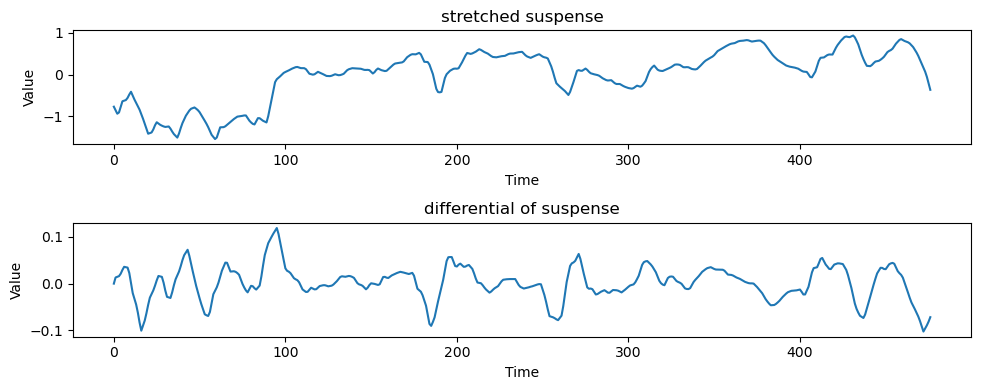

0    239
1    238
Name: count, dtype: int64


In [5]:
old_suspense = np.load('./data_files/avg_suspense.npy')

# 1. stretch suspense, via interpolation, to match the movie length
old_ts, expanded_ts = np.linspace(0, 1, len(old_suspense)), np.linspace(0, 1, len(df_encoding['trial_smooth_spikes'].iloc[0]))
suspense_interpolate_fn = interp1d(old_ts, old_suspense, kind='linear', fill_value="extrapolate")
stretched_suspense = suspense_interpolate_fn(expanded_ts)

# 2. obtain differential of suspense
diff_suspense = np.diff(stretched_suspense)
diff_suspense = np.insert(diff_suspense, 0, 0)
# smooth the differential using a moving average
diff_suspense = np.convolve(diff_suspense, np.ones(10) / 10, mode='same')
print(f'kernal thats being slid over: {np.ones(10) / 10}')

# plot
fig, axs = plt.subplots(2, 1, figsize=(10, 4))

titles = ['stretched suspense', 'differential of suspense']
ts_data = [stretched_suspense, diff_suspense]

for ax, title, values in zip(axs.flat, titles, ts_data):
    ax.plot(values)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# binarize suspense for classification
binary_suspense = (stretched_suspense > np.median(stretched_suspense)).astype(int)
print(pd.Series(binary_suspense).value_counts())

# gun: 3:30 (210s), 4:27 (267), 6:00 (360),  7:00 (420), 7:30 (450)
peak_suspense_ts = [210,  267, 370, 430, 460]

In [6]:
# t = len(stretched_suspense)
# mtx = np.zeros((t, t))

# for i in range(t):
#     for j in range(t):
#         mtx[i, j] = stretched_suspense[abs(i + j) % t]

# # Plot the matrix
# plt.figure(figsize=(4, 4))
# sns.heatmap(mtx, cmap='viridis', square=True, cbar_kws={'label': 'Suspense Value'})
# plt.title('Anti-Diagonal Suspense Matrix')
# plt.xlabel('Index j')
# plt.ylabel('Index i')
# plt.show()


## setting up plotting vars

In [7]:
num_bins = len(df_encoding['trial_smooth_spikes'].iloc[0])
x_time_points = np.linspace(1, np.max(df_encoding['RT']), num_bins)
color_map = {'ACC': 'purple', 'amygdala': 'green', 'hippocampus': 'blue', 'preSMA': 'red', 'vmPFC': 'orange'}

## save pickles

In [8]:
# for region in ['ACC', 'amygdala', 'hippocampus', 'preSMA', 'vmPFC']:

#     df_region = df_encoding[df_encoding['region'] == region]

#     # convert groupby obj to 2d array (neurons x time)
#     neur_by_time = np.array(df_region['trial_smooth_spikes'].tolist())
#     time_by_neur = neur_by_time.T

#     if time_by_neur.shape[1] % 2 == 1:
#         time_by_neur = time_by_neur[:, :-1]  # ensure even number of neurons
    
#     pd.DataFrame(time_by_neur).to_pickle(f'./data_files/time_by_neurs/{region}.pkl')

## optimal number of events across pseudo-population

In [9]:
# region = 'hippocampus'
# df_region = df_encoding[df_encoding['region'] == region]

# # convert groupby obj to 2d array (neurons x time)
# neur_by_time = np.array(df_region['trial_smooth_spikes'].tolist())
# time_by_neur = neur_by_time.T

# if time_by_neur.shape[1] % 2 == 1:
#     time_by_neur = time_by_neur[:, :-1]  # ensure even number of neurons
# print(f'time * neuron: {time_by_neur.shape}')

# num_events_arr = np.arange(50, 101, 10)
# train_lls, test_lls = np.zeros(len(num_events_arr)), np.zeros(len(num_events_arr))

# print(f'fitting ')
# for i, num_event in enumerate(num_events_arr):
# # optimizing over num_events

#     print(f'{num_event} events: ', end='')
    
#     cv_train_ll, cv_test_ll = [None]*5, [None]*5
#     for cv in range(5):
#     # 5-fold cross validation

#         # split neurons 50/50 by train & test
#         train_indices, test_indices = train_test_split(np.arange(time_by_neur.shape[1]), test_size=.5, random_state=42)
#         time_by_neur_train = time_by_neur[:, train_indices]
#         time_by_neur_test = time_by_neur[:, test_indices]

#         movie_HMM = EventSegment(num_event)
#         movie_HMM.fit(time_by_neur_train)
        
#         cv_train_ll[cv] = movie_HMM.ll_
#         _, cv_test_ll[cv] = movie_HMM.find_events(time_by_neur_test)

#     # print('avg LL=', np.mean(cv_test_ll))
    
#     train_lls[i] = np.mean(cv_train_ll)
#     test_lls[i] = np.mean(cv_test_ll)

# plt.figure(figsize=(4, 4))
# plt.plot(num_events_arr, train_lls)
# plt.plot(num_events_arr, test_lls)
# plt.xlabel('num_transitions')
# plt.ylabel('CV log-likelihood')
# plt.legend(['train', 'test'])

# movie_dur = time_by_neur.shape[0]
# secax = plt.gca().secondary_xaxis('top', functions=(lambda x: movie_dur / x, lambda x: movie_dur / x))
# secax.set_xlabel('avg event length (sec)')



In [10]:
plt.figure(figsize=(10, 3))
plt.plot(num_events_arr, train_lls)
plt.plot(num_events_arr, test_lls)
plt.xlabel('num_transitions')
plt.ylabel('CV log-likelihood')
plt.legend(['train', 'test'])

movie_dur = time_by_neur.shape[0]
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: movie_dur / x, lambda x: movie_dur / x))
secax.set_xlabel('avg event length (sec)')

NameError: name 'num_events_arr' is not defined

<Figure size 1000x300 with 0 Axes>

## neuron tuning to suspense

24


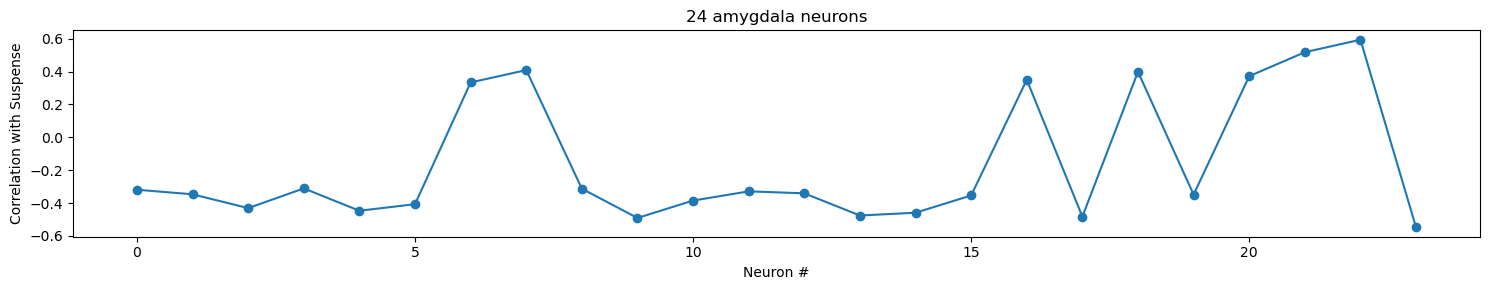

In [11]:
region = 'amygdala'
select_df = df_encoding[(df_encoding['region'] == region)].reset_index(drop=True)

half_len, corrs = len(stretched_suspense)//2, {}
p_thresh, r_thresh = 0.001, 0.3

for index, neur in select_df.iterrows():

    r, p = pearsonr(stretched_suspense, neur['trial_smooth_spikes'])
    if p < p_thresh and abs(r) > r_thresh:
    # 'sigfig' neurons
        corrs[neur['neuron']] = round(r, 3)
        # fig = plt.figure(figsize=(15, 3))
        # plt.plot(neur['trial_smooth_spikes'])
        # plt.plot(stretched_suspense)
        # plt.show()
        # break

print(len(corrs))

fig = plt.figure(figsize=(15, 3))
plt.plot(range(len(corrs)), corrs.values(), marker='o')
plt.xlabel('Neuron #')
plt.ylabel('Correlation with Suspense')
plt.title(f'{len(corrs)} {region} neurons')
plt.tight_layout()
plt.show()



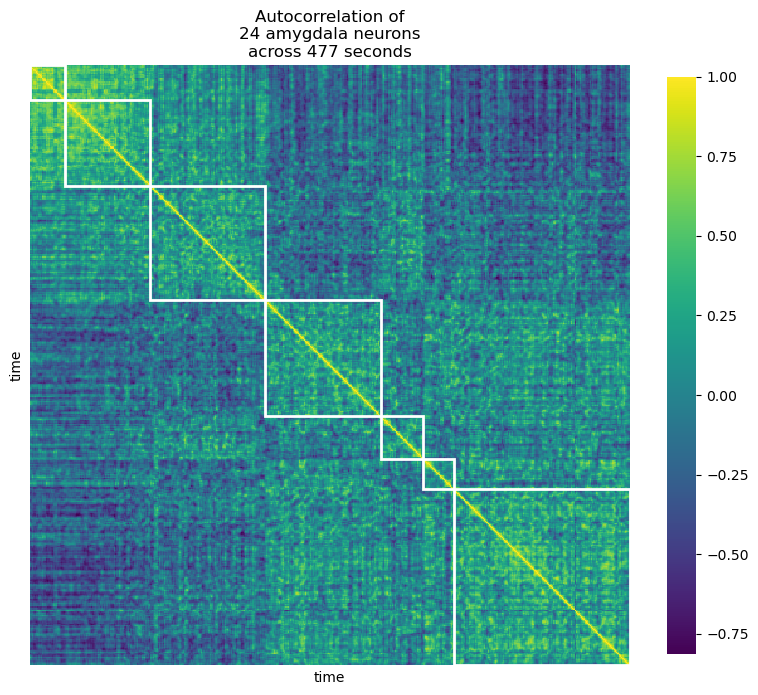

In [12]:
# create t-t correlation of sigfig amyg neurons
sigfig_neurs = corrs.keys()
sigfig_df = select_df[select_df['neuron'].isin(sigfig_neurs)]

neur_by_time = np.array(sigfig_df['trial_smooth_spikes'].tolist())
time_by_neur = neur_by_time.T
corr_matrix = np.corrcoef(time_by_neur)

##
movie_HMM = EventSegment(n_events=7)#, split_merge=True)
movie_HMM.fit(time_by_neur)
event_bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis=1)))[0]
n_ts = time_by_neur.shape[0]

# plot correlation matrix with boundaries
plt.figure(figsize=(8, 8))
ax = sns.heatmap(corr_matrix, cmap='viridis', square=True, cbar_kws={'shrink': 0.75})
plt.title(f'Autocorrelation of\n{time_by_neur.shape[1]} {region} neurons\nacross {len(stretched_suspense)} seconds')
plt.xlabel('time')
plt.ylabel('time')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# plot HMM boundaries in white
bounds_aug = np.concatenate(([0], event_bounds, [n_ts]))
for i in range(len(bounds_aug) - 1):
    rect = patches.Rectangle(
        (bounds_aug[i], bounds_aug[i]),
        bounds_aug[i + 1] - bounds_aug[i],
        bounds_aug[i + 1] - bounds_aug[i],
        linewidth=2, edgecolor='w', facecolor='none'
    )
    ax.add_patch(rect)

plt.show()

# # plot scene cuts in red
# for cut in scene_cuts:
#     axs[plot_i].axvline(cut, color='red', linestyle='-', linewidth=2)
#     axs[plot_i].axhline(cut, color='red', linestyle='-', linewidth=2)
# ##



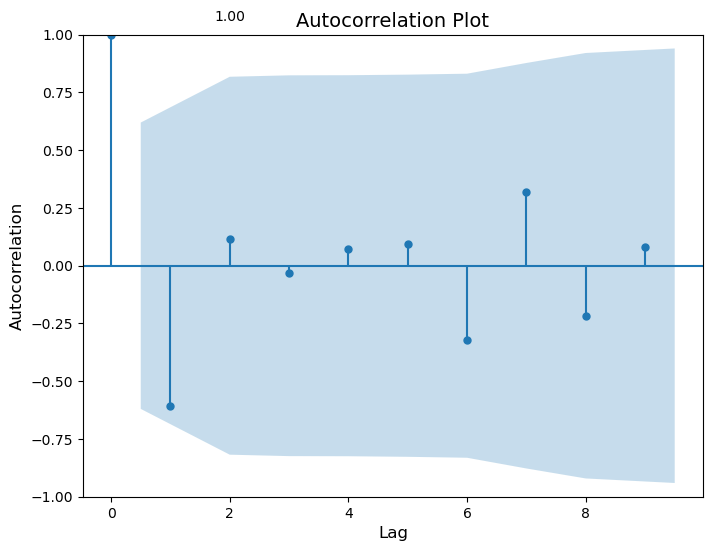

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Example data
data = [3, 7, 1, 8, 4, 6, 2, 5, 9, 0]

# Plot the autocorrelation
fig, ax = plt.subplots(figsize=(8, 6))
plot_acf(data, lags=9, ax=ax)

# Customize labels and title
ax.set_xlabel('Lag', fontsize=12)  # X-axis label
ax.set_ylabel('Autocorrelation', fontsize=12)  # Y-axis label
ax.set_title('Autocorrelation Plot', fontsize=14)

# Example of annotating a specific point on the plot
for i, value in enumerate(data[:9]):  # Annotate specific points (for first 9 lags)
    ax.annotate(f'{value:.2f}', (i, value), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()




## neuron & time predictors of suspense

(467, 240) (467,)


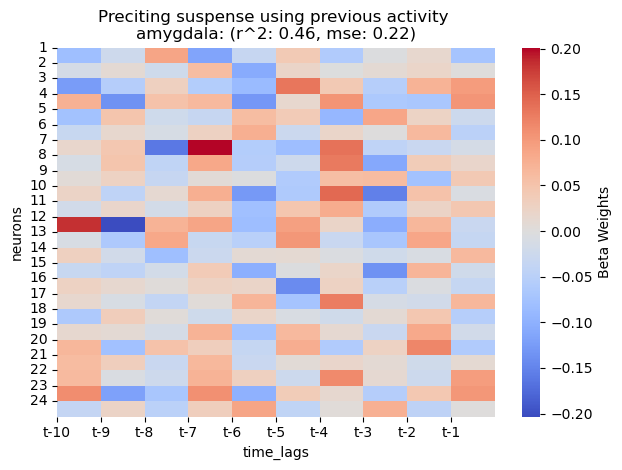

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from statsmodels.api import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler


max_lag = 10
features, labels = [], []

for y_t in range(max_lag, len(stretched_suspense)):
    
    features.append(neur_by_time[:, y_t-max_lag: y_t].flatten())
    labels.append(stretched_suspense[y_t])

features, labels = np.array(features), np.array(labels)

# normalize features
# scaler_X = MinMaxScaler()
# features = scaler_X.fit_transform(features)

print(features.shape, labels.shape)
# t*N and t, respectively
# t= 477-max_lag = 467, N = 24*max_lag = 240

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

glm = GLM(y_train, X_train, family=Gaussian())
reg = glm.fit()
weights, y_pred = reg.params, reg.predict(X_test)
mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

# reshape beta weights to neuron * time
weights_mtx = weights.reshape((neur_by_time.shape[0], max_lag))

sns.heatmap(weights_mtx, cmap='coolwarm', cbar_kws={'label': 'Beta Weights'})
plt.xlabel('time_lags')
plt.xticks(range(max_lag), [f't-{i}' for i in range(max_lag, 0, -1)])
plt.ylabel('neurons')
plt.yticks(range(neur_by_time.shape[0]), list(range(1, neur_by_time.shape[0]+1)))
plt.title(f'Preciting suspense using previous activity \n{region}: (r^2: {r2:.2f}, mse: {mse:.2f})')
plt.tight_layout()
plt.show()


## neuron & time predictors of avg neuron activity

(467, 240) (467,)


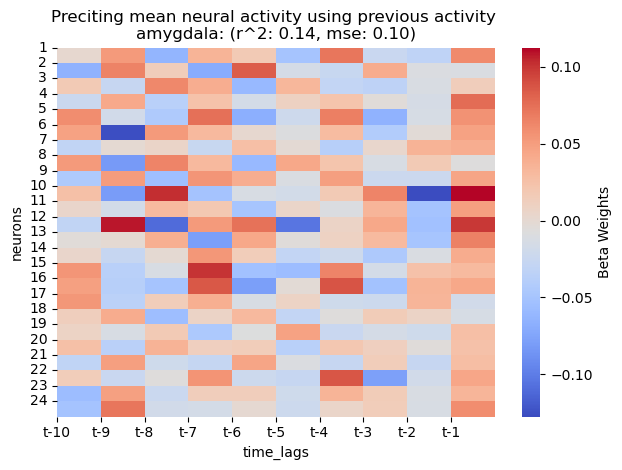

In [ ]:
max_lag = 10
features, labels = [], []

for y_t in range(max_lag, len(stretched_suspense)):
    
    features.append(neur_by_time[:, y_t-max_lag: y_t].flatten())
    labels.append(np.median(neur_by_time[:, y_t]))

features, labels = np.array(features), np.array(labels)

# normalizing features
# scaler_X = MinMaxScaler()
# features = scaler_X.fit_transform(features)

print(features.shape, labels.shape)
# t*N and t, respectively
# t= 477-max_lag = 467, N = 24*max_lag = 240

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

glm = GLM(y_train, X_train, family=Gaussian())
reg = glm.fit()
weights, y_pred = reg.params, reg.predict(X_test)
mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

# reshape beta weights to neuron * time
weights_mtx = weights.reshape((neur_by_time.shape[0], max_lag))

sns.heatmap(weights_mtx, cmap='coolwarm', cbar_kws={'label': 'Beta Weights'})
plt.xlabel('time_lags')
plt.xticks(range(max_lag), [f't-{i}' for i in range(max_lag, 0, -1)])
plt.ylabel('neurons')
plt.yticks(range(neur_by_time.shape[0]), list(range(1, neur_by_time.shape[0]+1)))
plt.title(f'Preciting mean neural activity using previous activity \n{region}: (r^2: {r2:.2f}, mse: {mse:.2f})')
plt.tight_layout()
plt.show()


# plotting each session

done with 
subjP43,  subjP43,  subjP44,  subjP47,  subjP48,  subjP48,  subjP49,  subjP51,  subjP54,  subjP54,  subjP55,  subjP58,  

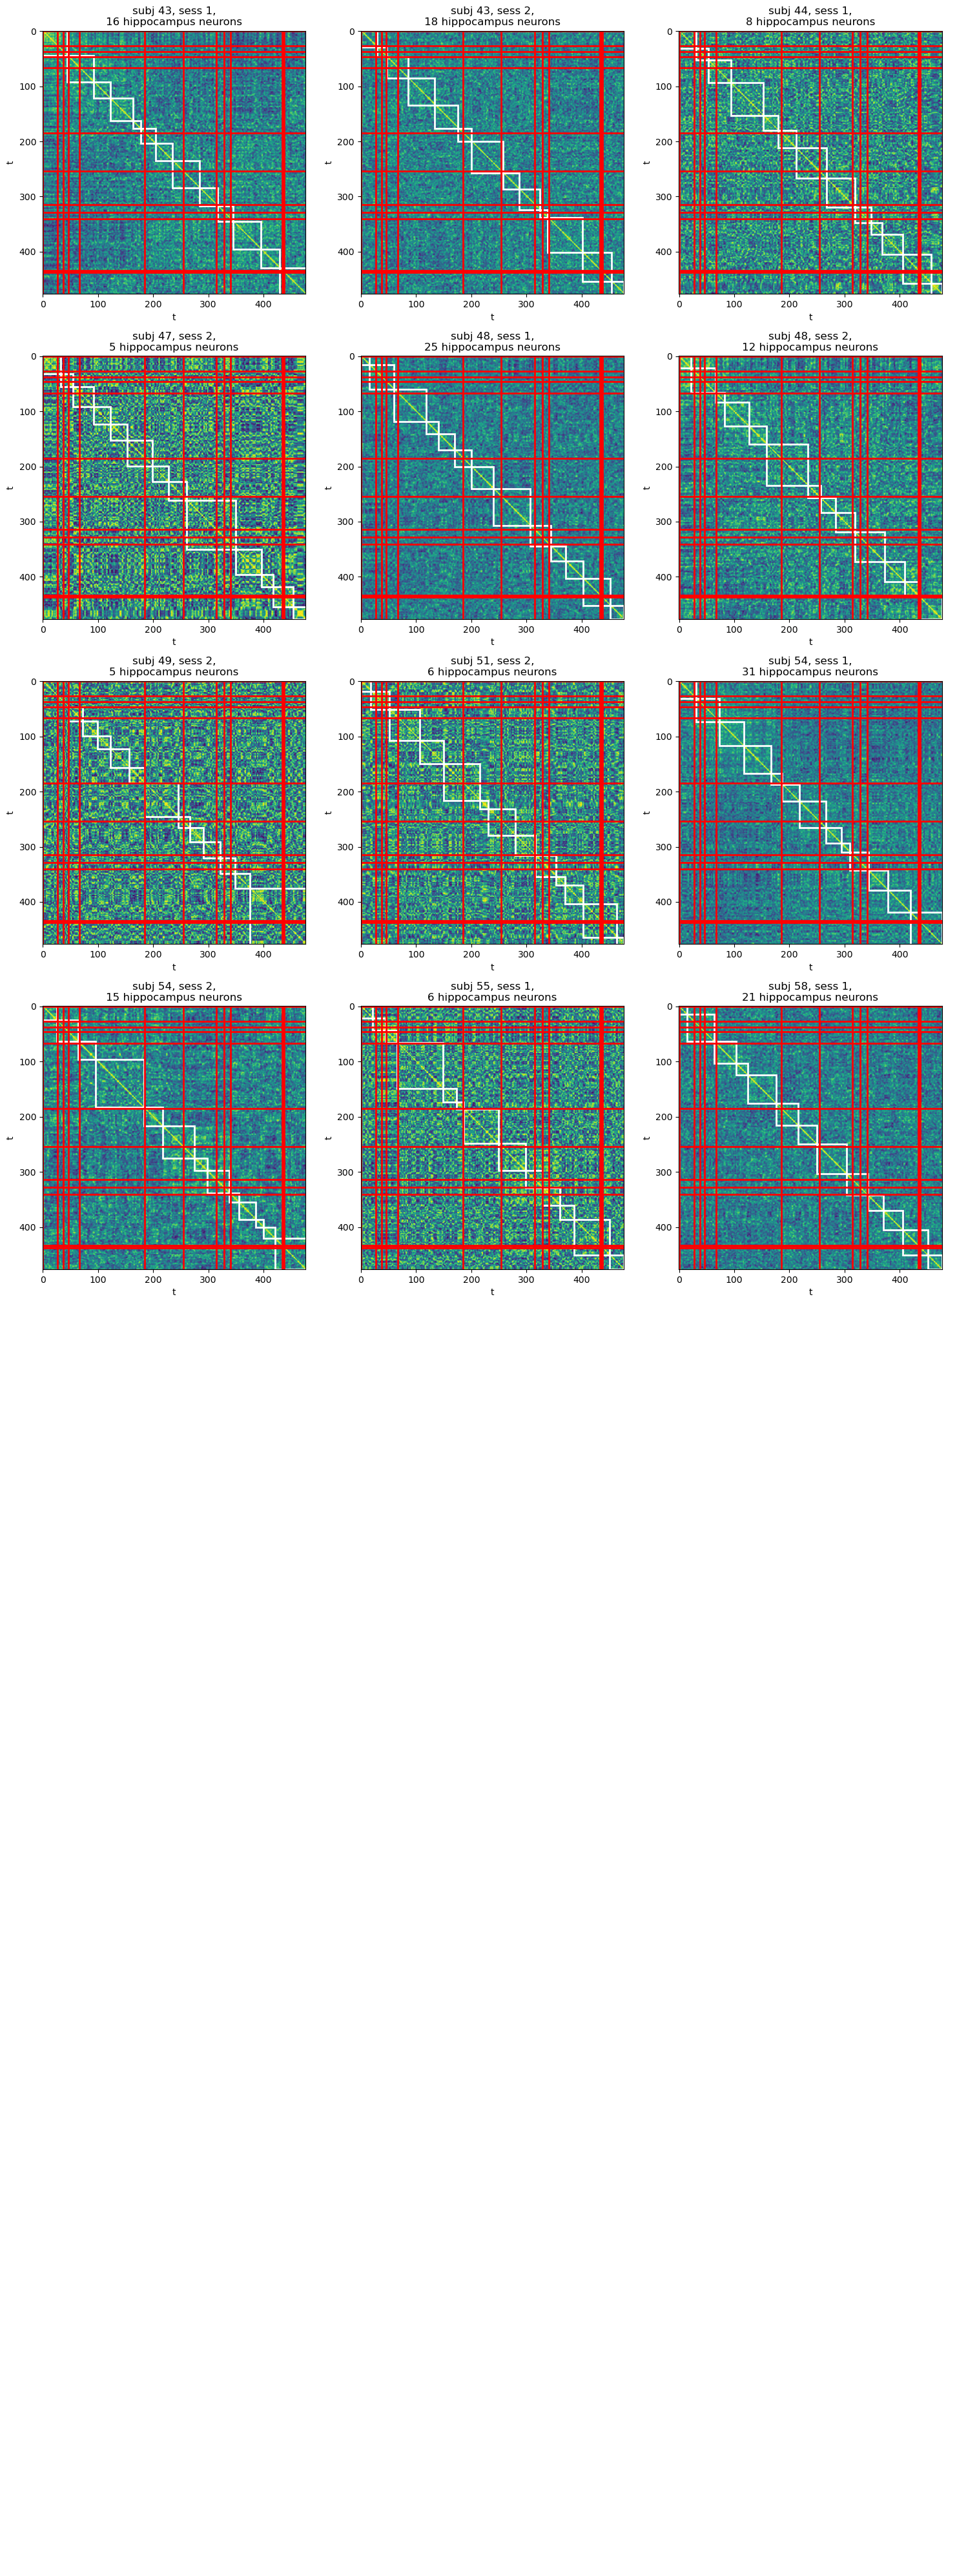

In [ ]:
region = 'hippocampus'
df_region = df_encoding[df_encoding['region'] == region]

nrows, ncols, subplot_ht = 8, 3, 5
fig_width, fig_height = 15, nrows*subplot_ht
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))
axs = axs.flatten()
plot_i = 0

print('done with ')
for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5:  # skip sessions with fewer than 5 neurons
        continue

    # convert groupby object to 2D array (neurons x time)
    subj, neur_by_time = session.split('CS')[0], np.array(session_df['trial_smooth_spikes'].tolist())
    time_by_neur = neur_by_time.T
    
    # fit HMM and identify event boundaries
    movie_HMM = EventSegment(n_events=13)#, split_merge=True)
    movie_HMM.fit(time_by_neur)
    event_bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis=1)))[0]
    n_ts = time_by_neur.shape[0]

    # # Plotting the log-likelihood (measuring overall model fit)
    # plt.figure(figsize = (12, 4))
    # plt.plot(movie_HMM.ll_)
    # plt.title('log likelihood, eg session')
    # plt.xlabel('n_iters')
    # plt.show()

    # correlation matrix with boundaries
    axs[plot_i].imshow(np.corrcoef(time_by_neur), cmap='viridis')
    axs[plot_i].set_title(f'subj {session[1:3]}, sess {session[-1]},\n{time_by_neur.shape[1]} {region} neurons')
    axs[plot_i].set_xlabel('t')
    axs[plot_i].set_ylabel('t')

    # plot HMM boundaries in white
    bounds_aug = np.concatenate(([0], event_bounds, [n_ts]))
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i + 1] - bounds_aug[i],
            bounds_aug[i + 1] - bounds_aug[i],
            linewidth=2, edgecolor='w', facecolor='none'
        )
        axs[plot_i].add_patch(rect)

    # plot scene cuts in red
    for cut in scene_cuts:
        axs[plot_i].axvline(cut, color='red', linestyle='-', linewidth=2)
        axs[plot_i].axhline(cut, color='red', linestyle='-', linewidth=2)

    plot_i += 1

    # break

# hide unused subplots
for i in range(plot_i, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()


done with 
time * neuron: (477, 16)
fitting 
10 events: 20 events: 30 events: 40 events: 50 events: 

KeyboardInterrupt: 

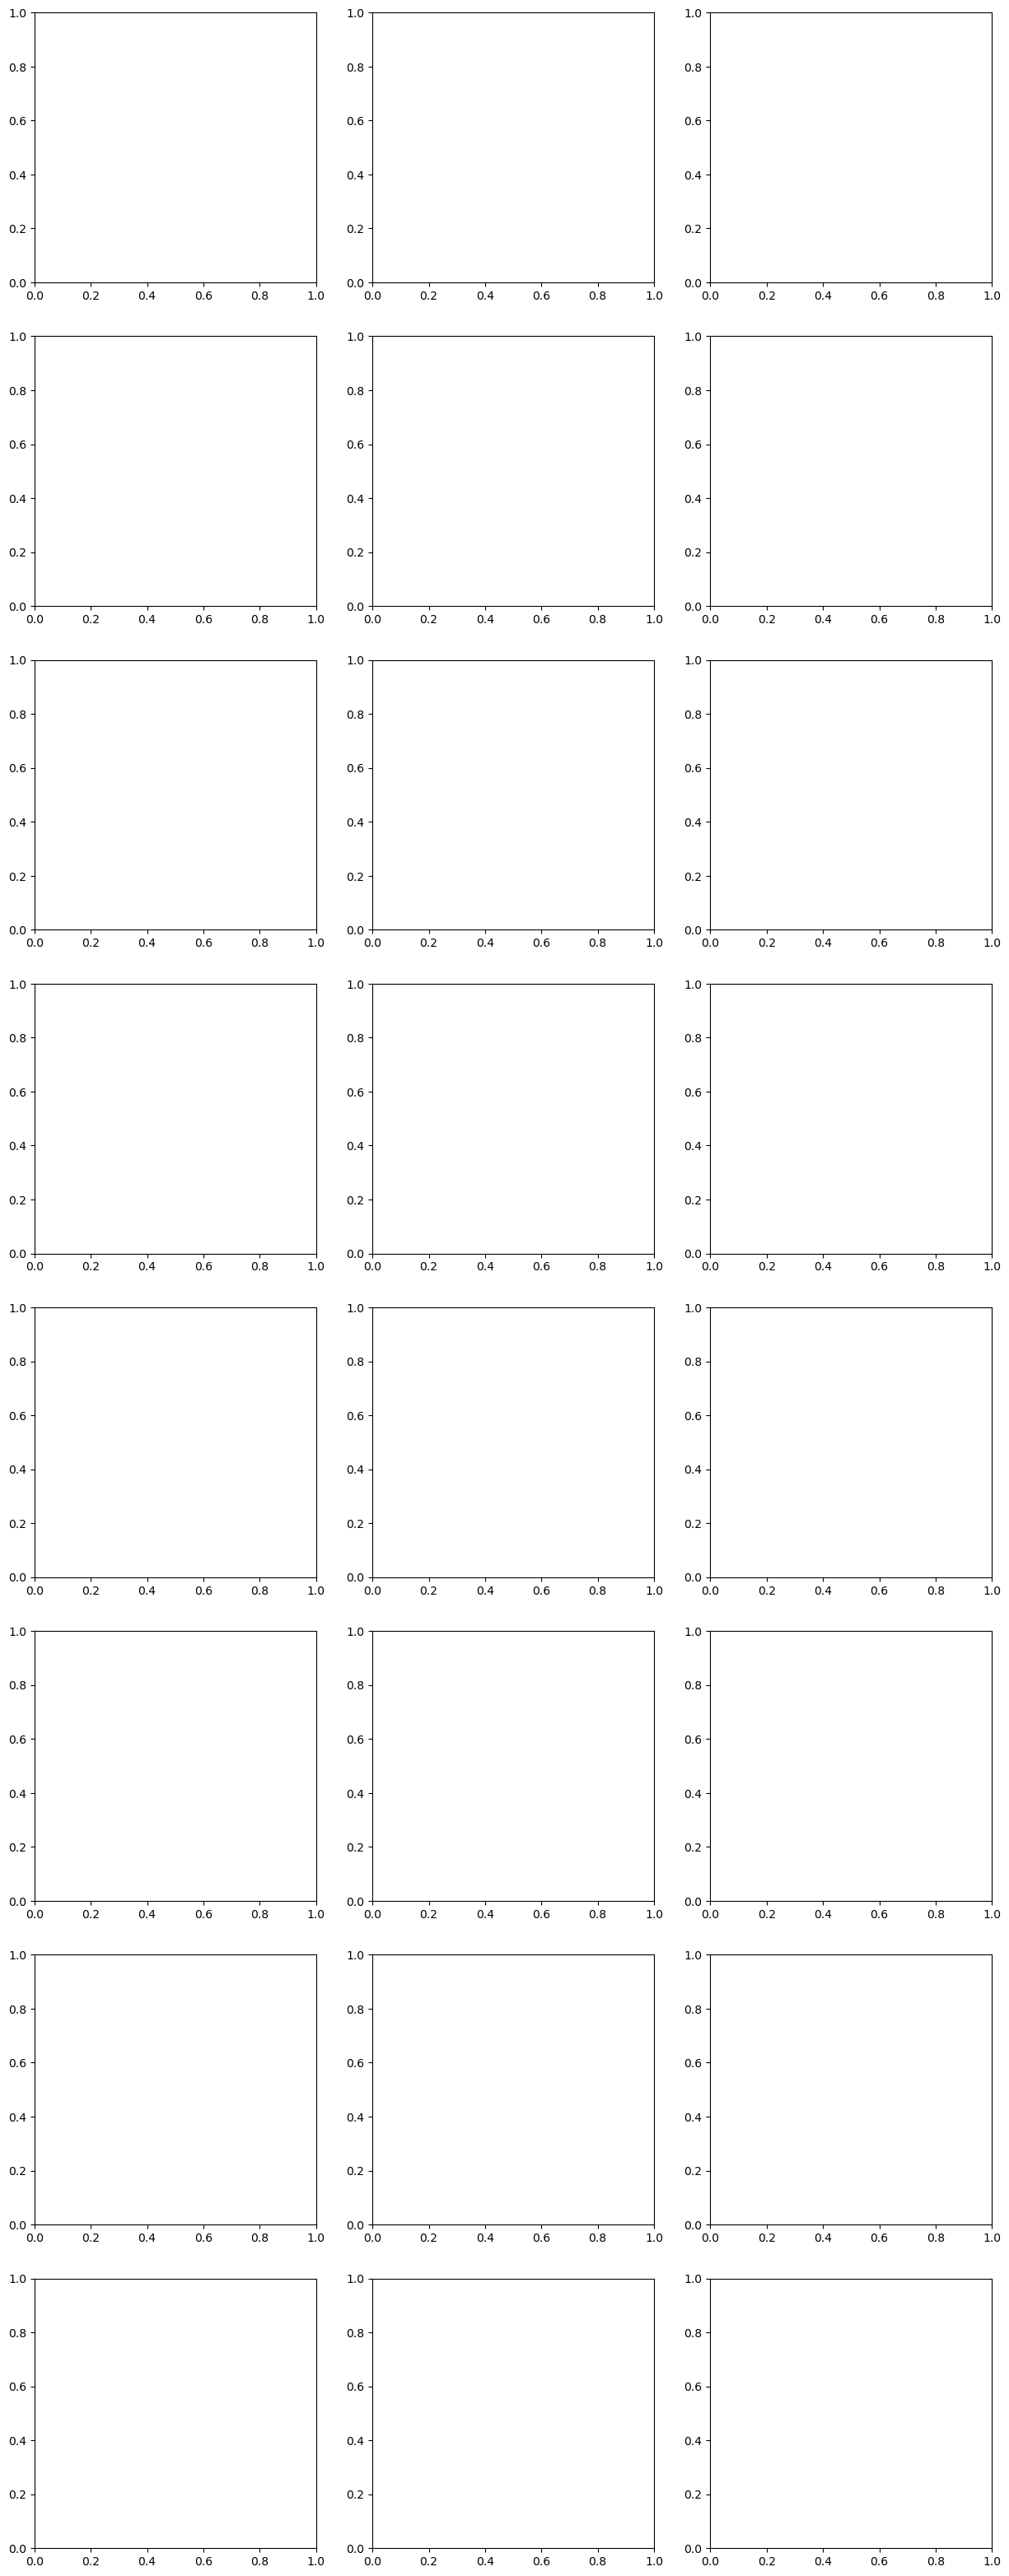

In [4]:
region = 'hippocampus'
df_region = df_encoding[df_encoding['region'] == region]

nrows, ncols, subplot_ht = 8, 3, 5
fig_width, fig_height = 15, nrows*subplot_ht
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))
axs = axs.flatten()
plot_i = 0

print('done with ')
for session, session_df in df_region.groupby('sess'):

    if len(session_df) < 5:  # skip sessions with fewer than 5 neurons
        continue

    # convert groupby object to 2D array (neurons x time)
    subj, neur_by_time = session.split('CS')[0], np.array(session_df['trial_smooth_spikes'].tolist())
    time_by_neur = neur_by_time.T
    

    if time_by_neur.shape[1] % 2 == 1:
        time_by_neur = time_by_neur[:, :-1]  # ensure even number of neurons
    print(f'time * neuron: {time_by_neur.shape}')

    num_events_arr = np.arange(10, 101, 10)
    train_lls, test_lls = np.zeros(len(num_events_arr)), np.zeros(len(num_events_arr))

    print(f'fitting ')
    for i, num_event in enumerate(num_events_arr):
    # optimizing over num_events

        print(f'{num_event} events: ', end='')
        
        cv_train_ll, cv_test_ll = [None]*5, [None]*5
        for cv in range(5):
        # 5-fold cross validation

            # split neurons 50/50 by train & test
            train_indices, test_indices = train_test_split(np.arange(time_by_neur.shape[1]), test_size=.5, random_state=42)
            time_by_neur_train = time_by_neur[:, train_indices]
            time_by_neur_test = time_by_neur[:, test_indices]

            movie_HMM = EventSegment(num_event)
            movie_HMM.fit(time_by_neur_train)
            
            cv_train_ll[cv] = movie_HMM.ll_
            _, cv_test_ll[cv] = movie_HMM.find_events(time_by_neur_test)

        # print('avg LL=', np.mean(cv_test_ll))
        
        train_lls[i] = np.mean(cv_train_ll)
        test_lls[i] = np.mean(cv_test_ll)

    plt.figure(figsize=(4, 4))
    plt.plot(num_events_arr, train_lls)
    plt.plot(num_events_arr, test_lls)
    plt.xlabel('num_transitions')
    plt.ylabel('CV log-likelihood')
    plt.legend(['train', 'test'])


    # break


    # fit HMM and identify event boundaries
    movie_HMM = EventSegment(n_events=13)#, split_merge=True)
    movie_HMM.fit(time_by_neur)
    event_bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis=1)))[0]
    n_ts = time_by_neur.shape[0]

    # # Plotting the log-likelihood (measuring overall model fit)
    # plt.figure(figsize = (12, 4))
    # plt.plot(movie_HMM.ll_)
    # plt.title('log likelihood, eg session')
    # plt.xlabel('n_iters')
    # plt.show()

    # correlation matrix with boundaries
    axs[plot_i].imshow(np.corrcoef(time_by_neur), cmap='viridis')
    # axs[plot_i].imshow(mtx, cmap='viridis')
    axs[plot_i].set_title(f'subj {session[1:3]}, sess {session[-1]},\n{time_by_neur.shape[1]} {region} neurons')
    axs[plot_i].set_xlabel('t')
    axs[plot_i].set_ylabel('t')

    # plot HMM boundaries in white
    bounds_aug = np.concatenate(([0], event_bounds, [n_ts]))
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i + 1] - bounds_aug[i],
            bounds_aug[i + 1] - bounds_aug[i],
            linewidth=2, edgecolor='w', facecolor='none'
        )
        axs[plot_i].add_patch(rect)

    for cut in scene_cuts:
        axs[plot_i].axvline(cut, color='red', linestyle='-', linewidth=2)
        axs[plot_i].axhline(cut, color='red', linestyle='-', linewidth=2)

    plot_i += 1
    print(f'subj{subj}, ', end=' ')

    # break

# hide unused subplots
for i in range(plot_i, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()
